In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import create_data_for_RNN, plot_losses, plot_histogram_and_save

from tools.ae_v2 import Autoencoder

from tools.ESN_v1 import ESN as RNN_SingleStep
from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v1 import AR_AERNN_ESN as AR_AERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            # tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
            tf.config.set_visible_devices([], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[]


2023-07-17 20:09:52.291746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 20:09:52.346410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 20:09:52.346658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 20:09:52.348194: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_ESN_ensemble'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'ESN_ensemble_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # whether to use AE data or just work on raw data
    use_ae_data = True # if false, specifying ae_idx will only show which dataset to use
    
    # autoencoder directory
    ae_idx = '024'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    use_ae_data = params_dict['use_ae_data']
    
    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    # initial_t0 = fl['initial_t0']
    # init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ESN_ensemble/ESN_ensemble_005
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s


In [14]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data, axis=0)
time_mean_ogdata = np.mean(all_data, axis=0)

if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
        normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]
    normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:og_vars]

# Autoencoder

In [15]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [16]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [17]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

In [18]:
# plot_latent_states_KS(
#     boundary_idx_arr,
#     latent_states_all,
#     delta_t,
#     dir_name_ae,
#     xticks_snapto=int(40*np.round((T//10)/40)),
#     num_yticks=11,
#     save_figs=False)

In [19]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# ESN

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    dt_rnn = 0.1
    num_input_tsteps = 20000
    T_sample_input = num_input_tsteps*dt_rnn
    T_sample_output = T_sample_input
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    ESN_layers_units = [num_latent_states*800] # [num_latent_states*1500]
    stateful = True
    omega_in = [1.91292074e+00]
    degree_of_connectivity = [3]
    rho_res = [4.56948506e-01]
    usebias_Win = [False]
    alpha = [7.53730808e-01]
    ESN_cell_activations = ['tanh']
    usebias_Wout = True
    
    activation_post_Wout = 'linear'
    use_weights_post_dense = False
    
    # computing sparsity
    sparsity = [1-degree_of_connectivity[i]/(ESN_layers_units[i]-1) for i in range(len(ESN_layers_units))]
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        # 'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
        'use_ae_data':use_ae_data,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_input_tsteps':num_input_tsteps,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_SingleStep.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [21]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [22]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [23]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [24]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    num_ensemble_mems = 10
    epochs = 1
    lambda_reg = 1.00000000e-09 # weight for regularizer
    min_delta = 1e-6
    patience = 5
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 1
    fRMS = 2.72646503e-02
    use_best = False

    stddev = fRMS * np.mean(time_stddev[0:og_vars]) # fRMS*timeMeanofSpaceRMS
    
    # ph computation parameters
    num_runs = 100
    T_sample_input_AR_ratio = 1
    T_sample_output_AR_ratio = 10
    
    # saving training params
    training_specific_params = {
        'epochs':epochs,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'lambda_reg':lambda_reg,
        'min_delta':min_delta,
        'patience':patience,
        'use_best':use_best,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    epochs = tparams_dict['epochs']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    lambda_reg = tparams_dict['lambda_reg']
    min_delta = tparams_dict['min_delta']
    patience = tparams_dict['patience']
    try:
        use_best = tparams_dict['use_best']
    except:
        print("'use_best' not present in 'training_specific_params', set to True.")
        use_best = True

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [25]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = batch_size * int((rnn_data_boundary_idx_arr[i] - begin_idx) // batch_size)
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]

    AR_testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_input[idx[num_train+num_val:num_samples]]
    AR_testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_output[idx[num_train+num_val:num_samples]]

    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [26]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (16, 20000, 2)
  training_data_rnn_output.shape :  (16, 20000, 2)
    testing_data_rnn_input.shape :  (2, 20000, 2)
   testing_data_rnn_output.shape :  (2, 20000, 2)
        val_data_rnn_input.shape :  (2, 20000, 2)
       val_data_rnn_output.shape :  (2, 20000, 2)

 AR_testing_data_rnn_input.shape :  (2, 20000, 3)
AR_testing_data_rnn_output.shape :  (2, 20000, 3)


In [27]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  100


In [28]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [29]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [30]:
s =  '   training_data_rnn_input.shape : {}\n'.format(training_data_rnn_input.shape)
s += '  training_data_rnn_output.shape : {}\n'.format(training_data_rnn_output.shape)
s += '    testing_data_rnn_input.shape : {}\n'.format(testing_data_rnn_input.shape)
s += '   testing_data_rnn_output.shape : {}\n'.format(testing_data_rnn_output.shape)
s += '        val_data_rnn_input.shape : {}\n'.format(val_data_rnn_input.shape)
s += '       val_data_rnn_output.shape : {}\n\n'.format(val_data_rnn_output.shape)
# s += ''
s += ' AR_testing_data_rnn_input.shape : {}\n'.format(AR_testing_data_rnn_input.shape)
s += 'AR_testing_data_rnn_output.shape : {}'.format(AR_testing_data_rnn_output.shape)

In [31]:
print(s)

   training_data_rnn_input.shape : (16, 20000, 2)
  training_data_rnn_output.shape : (16, 20000, 2)
    testing_data_rnn_input.shape : (2, 20000, 2)
   testing_data_rnn_output.shape : (2, 20000, 2)
        val_data_rnn_input.shape : (2, 20000, 2)
       val_data_rnn_output.shape : (2, 20000, 2)

 AR_testing_data_rnn_input.shape : (100, 11, 3)
AR_testing_data_rnn_output.shape : (100, 110, 3)


In [32]:
with open(dir_name_rnn+'/data_shape.txt', 'w') as f:
    f.write(s)

In [33]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    ensemble_lst = []
    for i in range(num_ensemble_mems):
        rnn_net = RNN_SingleStep(
            data_dim=data_dim,
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            ESN_layers_units=ESN_layers_units,
            stddev=stddev,
            noise_type=noise_type,
            stateful=stateful,
            omega_in=omega_in,
            sparsity=sparsity,
            rho_res=rho_res,
            usebias_Win=usebias_Win,
            alpha=alpha,
            ESN_cell_activations=ESN_cell_activations,
            prng_seed=np.random.randint(low=0, high=prng_seed)*prng_seed,
            usebias_Wout=usebias_Wout,
            use_weights_post_dense=use_weights_post_dense,
            activation_post_Wout=activation_post_Wout,
            scalar_weights=[],
        )
        rnn_net.build(input_shape=(1,) + training_data_rnn_input.shape[1:])
        rnn_net.save_class_dict(save_path+dir_sep+'{}_final_net_class_dict.txt'.format(i))
        ensemble_lst.append(rnn_net)
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    
    rnn_net = RNN_SingleStep(
        load_file=load_file,
    )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_ESN_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.2933353
stddev : 0.009068882412693047


In [34]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
# elif behaviour == 'loadCheckpointAndContinueTraining':
#     val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
#         dir_name_ae=dir_name_rnn,
#         dir_sep=dir_sep,
#         epochs=epochs,
#         learning_rate_list=learning_rate_list,
#         return_earlystopping_wait=True)
#     savelosses_cb_vallossarr = val_loss_arr_fromckpt
#     savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [35]:
def invert_fn(y):
    # post_Wout_activation = 'linear'
    return y

# def invert_fn(y):
#     # post_Wout_activation = 'tanh'
#     y = np.where(y < 1.0, y, 1-1e-6)
#     y = np.where(y > -1.0, y, -1+1e-6)
#     y = 0.5*(np.log(1+y) - np.log(1-y))
#     return y
    

In [36]:
training_data_rnn_input.dtype

dtype('float32')

In [37]:
for i_en in range(num_ensemble_mems):
    print('--- ENSEMBLE MEMBER {}/{} ---'.format(i_en+1, num_ensemble_mems))
    rnn_net = ensemble_lst[i_en]
    # compiling the network
    rnn_net.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=losses.MeanSquaredError(),
        metrics=['mse'],
        run_eagerly=False
    )

    lambda_reg = float(lambda_reg)

    if behaviour == 'loadCheckpointAndContinueTraining':
        # this loads the weights/attributes of the optimizer as well
        rnn_net.load_weights(wt_file)

    if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':

        Wout_best = 0
        val_mse_best = np.inf
        Wout_candidate = 0
        wait = 0
        if use_weights_post_dense == True:
            postWout_candidate = 0
            h_activation = tf.keras.activations.get(activation_post_Wout)


        hidden_units = ESN_layers_units[-1]
        output_units = rnn_net.data_dim

        Hb_shape = [hidden_units, hidden_units]
        Yb_shape = [output_units, hidden_units]
        if usebias_Wout == True:
            Hb_shape[0] += 1
            Hb_shape[1] += 1
            Yb_shape[1] += 1

        Hb = np.zeros(shape=Hb_shape, dtype=FTYPE)
        Yb = np.zeros(shape=Yb_shape, dtype=FTYPE)
        eye_Hb = np.eye(Hb.shape[0], dtype=FTYPE)

        num_batches = training_data_rnn_input.shape[0]


        for i in range(epochs):
            # for layer in rnn_net.ESN_layers:
            #     layer.reset_states()

            epoch_totaltime = time.time()

            total_s_len = 80
            sep_lr_s = ' EPOCH : {} '.format(i+1)
            sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
            sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
            print('\n\n' + '-'*len(sep_lr_s))
            print('\n' + sep_lr_s+'\n')
            print('-'*len(sep_lr_s) + '\n\n')

            # '''
            ### computing Wout
            Hb[:, :] = 0
            Yb[:, :] = 0
            epoch_time = time.time()
            avg_time = 0.
            num_runs = training_data_rnn_input.shape[0]
            for j in range(num_runs):
                batch_time = time.time()
                h = np.array(rnn_net(training_data_rnn_input[j:j+1], manual_training=True))
                # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
                # print(h.shape)
                h = h[0]
                # y = tf.constant(training_data_rnn_output[j])
                y = invert_fn(training_data_rnn_output[j])
                if usebias_Wout == True:
                    h = np.concatenate((h, np.ones(shape=(h.shape[0], 1))), axis=1)
                Hb = Hb + np.matmul(np.transpose(h), h)
                Yb = Yb + np.matmul(np.transpose(y), h)
                # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
                # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)
                batch_time = time.time() - batch_time
                avg_time = (avg_time*j + batch_time)/(j+1)
                eta = avg_time * (num_runs-1 - j)
                print('{} / {} -- Wout batch_time : {:.2f} s -- eta : {:.0f}h {:.0f}m {:.0f}s'.format(
                    j+1,
                    num_runs,
                    batch_time,
                    float(eta // 3600),
                    float((eta%3600)//60),
                    float((eta%3600)%60),
                ))

            Wout = np.matmul(
                Yb,
                np.linalg.inv(Hb + lambda_reg*np.eye(Hb.shape[0]))
            )
            Wout = np.transpose(Wout)
            # Wout = tf.linalg.matmul(
            #     Yb,
            #     tf.linalg.inv(Hb + lambda_reg*tf.eye(Hb.shape[0]))
            # )
            # Wout = tf.transpose(Wout)

            if use_weights_post_dense == True:
                ### computing postWout
                HYb = 0
                HHb = 0
                for j in range(training_data_rnn_input.shape[0]):
                    batch_time = time.time()
                    h = np.array(rnn_net(training_data_rnn_input[j:j+1], training=True))
                    # h = rnn_net(training_data_rnn_input[j:j+1], training=True)
                    # print(h.shape)
                    h = h[0]
                    h = np.matmul(h, Wout[0:ESN_layers_units[-1], :])
                    if usebias_Wout == True:
                        h = h + Wout[ESN_layers_units[-1]:, :]
                    # y = tf.constant(training_data_rnn_output[j])
                    h = np.array(h_activation(h))
                    y = training_data_rnn_output[j]
                    HYb = HYb + np.sum(h*y, axis=0)
                    HHb = HHb + np.sum(h**2, axis=0)
                    # Hb = Hb + tf.linalg.matmul(tf.transpose(h), h)
                    # Yb = Yb + tf.linalg.matmul(tf.transpose(y), h)

                    print('{} / {} -- postWout batch_time : {} sec'.format(
                        j+1,
                        training_data_rnn_input.shape[0],
                        time.time() - batch_time
                    ))

                postWout = HYb / (HHb + lambda_reg)

            print('\nepoch_time : {} sec'.format(time.time() - epoch_time))

            '''
            epoch_time = time.time()
            Wout = batched_computation(
                num_batches,
                rnn_net,
                training_data_rnn_input,
                training_data_rnn_output,
                usebias_Wout,
                Hb, Yb,
                hidden_units, output_units,
                lambda_reg, eye_Hb)
            print('\nepoch_time : {} sec'.format(time.time() - epoch_time))

            Hb[:, :] = 0.0
            Yb[:, :] = 0.0
            '''

            Wout_candidate = Wout_candidate*i/(i+1) + Wout*1/(i+1)
            tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_candidate[0:ESN_layers_units[-1], :])
            if usebias_Wout == True:
                tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_candidate[-1, :])

            if use_weights_post_dense == True:
                postWout_candidate = postWout_candidate*i/(i+1) + postWout*1/(i+1)
                tf.keras.backend.set_value(rnn_net.postWout.individual_weights, postWout_candidate)

            for layer in rnn_net.ESN_layers:
                layer.reset_states()

            print('\nval mse')
            # '''
            val_mse = 0
            for j in range(val_data_rnn_input.shape[0]):
                batch_time = time.time()
                val_pred = np.array(rnn_net(val_data_rnn_input[j:j+1], training=False))
                temp = (val_pred - val_data_rnn_output[j:j+1])**2
                temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
                temp = np.mean(temp, axis=-1)
                temp = np.mean(temp, axis=-1)
                val_mse = val_mse*j/(j+1) + temp*1/(j+1)
                print('{} / {} -- batch_time : {} sec'.format(
                    j+1,
                    val_data_rnn_input.shape[0],
                    time.time() - batch_time
                ))
            '''
            mse_time = time.time()
            val_mse = compute_mse(
                val_data_rnn_input,
                val_data_rnn_output,
                rnn_net)
            mse_time = time.time() - mse_time
            print('val_mse compute time : {} sec'.format(mse_time))
            '''

            for layer in rnn_net.ESN_layers:
                layer.reset_states()

            print('\ntraining mse')
            # '''
            train_mse = 0
            for j in range(training_data_rnn_input.shape[0]):
                batch_time = time.time()
                train_pred = np.array(rnn_net(training_data_rnn_input[j:j+1], training=False))
                temp = (train_pred - training_data_rnn_output[j:j+1])**2
                temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
                temp = np.mean(temp, axis=-1)
                temp = np.mean(temp, axis=-1)
                train_mse = train_mse*j/(j+1) + temp*1/(j+1)
                print('{} / {} -- batch_time : {} sec'.format(
                    j+1,
                    training_data_rnn_input.shape[0],
                    time.time() - batch_time
                ))
            '''
            mse_time = time.time()
            train_mse = compute_mse(
                training_data_rnn_input,
                training_data_rnn_output,
                rnn_net)
            mse_time = time.time() - mse_time
            print('train_mse compute time : {} sec'.format(mse_time))
            '''

            for layer in rnn_net.ESN_layers:
                layer.reset_states()

    #         print('\ntesting mse')
    #         test_mse = 0
    #         for j in range(testing_data_rnn_input.shape[0]):
    #             print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
    #             test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
    #             temp = (test_pred - testing_data_rnn_output[j:j+1])**2
    #             temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
    #             temp = np.mean(temp, axis=-1)
    #             temp = np.mean(temp, axis=-1)
    #             test_mse = test_mse*j/(j+1) + temp*1/(j+1)

    #         for layer in rnn_net.ESN_layers:
    #             layer.reset_states()

            val_loss_hist.append(val_mse)
            train_loss_hist.append(train_mse)

            # print('\ntest_mse : {}'.format(test_mse))
            print('\ntrain_mse : {}'.format(train_mse))
            print('val_mse : {}'.format(val_mse))
            if val_mse + min_delta <= val_mse_best:
                print('val_mse improved from {}'.format(val_mse_best))
                Wout_best = Wout_candidate
                val_mse_best = val_mse
                wait = 0
            else:
                wait += 1
                print('val_mse did not improve from {}, wait : {}'.format(val_mse_best, wait))

            print('\nTotal epoch computation time : {} sec'.format(time.time()-epoch_totaltime))

            if wait >= patience:
                print('\nearly stopping')
                break

    #         val_loss_hist.extend(history.history['val_loss'])
    #         train_loss_hist.extend(history.history['loss'])

    #         if i == starting_lr_idx:
    #             lr_change[i+1] += len(history.history['val_loss'])
    #         else:
    #             lr_change.append(lr_change[i]+len(history.history['val_loss']))

    # tf.keras.backend.set_value(rnn_net.Wout, Wout_best)

    if use_best == True:
        tf.keras.backend.set_value(rnn_net.Wout.kernel, Wout_best[0:ESN_layers_units[-1], :])
        if usebias_Wout == True:
            tf.keras.backend.set_value(rnn_net.Wout.bias, Wout_best[-1, :])
    print('\ntest mse')
    test_mse = 0
    for j in range(testing_data_rnn_input.shape[0]):
        print('{} / {}'.format(j+1, testing_data_rnn_input.shape[0]))
        test_pred = np.array(rnn_net(testing_data_rnn_input[j:j+1], training=False))
        temp = (test_pred - testing_data_rnn_output[j:j+1])**2
        temp = np.mean(temp, axis=-1) # do a sqrt here to get rmse
        temp = np.mean(temp, axis=-1)
        temp = np.mean(temp, axis=-1)
        test_mse = test_mse*j/(j+1) + temp*1/(j+1)
    print('test_mse : {}'.format(test_mse))

    for layer in rnn_net.ESN_layers:
        layer.reset_states()
        
    with open(save_path+dir_sep+'{}_losses.txt'.format(i_en), 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
#             'lr_change':lr_change,
            'test_loss':test_mse
        }))


    rnn_net.save_everything(
        file_name=save_path+dir_sep+'{}_final_net'.format(i_en))
    
    # # plotting losses
    # dir_name_plot = dir_name_rnn+dir_sep+'plots'
    # if not os.path.isdir(dir_name_plot):
    #     os.makedirs(dir_name_plot)

    # # Visualize loss history
    # fig, ax = plot_losses(
    #     training_loss=train_loss_hist,
    #     val_loss=val_loss_hist,
    #     lr_change=None,
    #     learning_rate_list=None
    # )

    # plt.savefig(dir_name_rnn+'{ds}plots{ds}{oo}_loss_history.png'.format(ds=dir_sep, oo=i_en), dpi=300, bbox_inches='tight')
    # plt.show()


--- ENSEMBLE MEMBER 1/10 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wout batch_time : 2.58 s -- eta : 0h 0m 39s
2 / 16 -- Wout batch_time : 1.48 s -- eta : 0h 0m 28s
3 / 16 -- Wout batch_time : 2.09 s -- eta : 0h 0m 27s
4 / 16 -- Wout batch_time : 2.34 s -- eta : 0h 0m 25s
5 / 16 -- Wout batch_time : 1.76 s -- eta : 0h 0m 23s
6 / 16 -- Wout batch_time : 1.77 s -- eta : 0h 0m 20s
7 / 16 -- Wout batch_time : 2.00 s -- eta : 0h 0m 18s
8 / 16 -- Wout batch_time : 2.00 s -- eta : 0h 0m 16s
9 / 16 -- Wout batch_time : 1.71 s -- eta : 0h 0m 14s
10 / 16 -- Wout batch_time : 2.03 s -- eta : 0h 0m 12s
11 / 16 -- Wout batch_time : 1.87 s -- eta : 0h 0m 10s
12 / 16 -- Wout batch_time : 2.05 s -- eta : 0h 0m 8s
13 / 16 -- Wout batch_time : 1.94 s -- eta : 0h 0m 6s
14 / 16 -- Wout ba

6 / 16 -- batch_time : 1.3631038665771484 sec
7 / 16 -- batch_time : 1.017618179321289 sec
8 / 16 -- batch_time : 0.9312033653259277 sec
9 / 16 -- batch_time : 0.9730095863342285 sec
10 / 16 -- batch_time : 1.009605884552002 sec
11 / 16 -- batch_time : 0.92006516456604 sec
12 / 16 -- batch_time : 1.0968589782714844 sec
13 / 16 -- batch_time : 0.9436168670654297 sec
14 / 16 -- batch_time : 1.3501358032226562 sec
15 / 16 -- batch_time : 0.8859086036682129 sec
16 / 16 -- batch_time : 1.4114718437194824 sec

train_mse : 0.0008151807633112185
val_mse : 0.0008202975732274354
val_mse improved from inf

Total epoch computation time : 51.6442768573761 sec

test mse
1 / 2
2 / 2
test_mse : 0.0008180989534594119
--- ENSEMBLE MEMBER 5/10 ---


--------------------------------------------------------------------------------

---------------------------------- EPOCH : 1 -----------------------------------

--------------------------------------------------------------------------------


1 / 16 -- Wo

11 / 16 -- Wout batch_time : 1.72 s -- eta : 0h 0m 9s
12 / 16 -- Wout batch_time : 1.56 s -- eta : 0h 0m 7s
13 / 16 -- Wout batch_time : 1.80 s -- eta : 0h 0m 5s
14 / 16 -- Wout batch_time : 1.67 s -- eta : 0h 0m 4s
15 / 16 -- Wout batch_time : 1.72 s -- eta : 0h 0m 2s
16 / 16 -- Wout batch_time : 1.50 s -- eta : 0h 0m 0s

epoch_time : 28.23436212539673 sec

val mse
1 / 2 -- batch_time : 0.9514749050140381 sec
2 / 2 -- batch_time : 1.0092270374298096 sec

training mse
1 / 16 -- batch_time : 1.5251567363739014 sec
2 / 16 -- batch_time : 0.8527061939239502 sec
3 / 16 -- batch_time : 1.4249117374420166 sec
4 / 16 -- batch_time : 0.9091858863830566 sec
5 / 16 -- batch_time : 1.1588876247406006 sec
6 / 16 -- batch_time : 1.0887782573699951 sec
7 / 16 -- batch_time : 1.2949931621551514 sec
8 / 16 -- batch_time : 1.089021921157837 sec
9 / 16 -- batch_time : 0.979597806930542 sec
10 / 16 -- batch_time : 1.0632140636444092 sec
11 / 16 -- batch_time : 1.024749755859375 sec
12 / 16 -- batch_time 

In [38]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

In [39]:
def get_ensemble_prediction(ensemble_lst, inputs, kwargs={}):
    pred = 0
    for i in range(len(ensemble_lst)):
        pred += np.array(ensemble_lst[i](inputs, **kwargs))
    pred /= len(ensemble_lst)
    return pred

In [40]:
def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    new_data[:] = data[:]
    new_data *= normalization_arr[1]
    new_data += normalization_arr[0]
    return new_data

In [41]:
# data_in = testing_data_rnn_input
# data_out = testing_data_rnn_output

# data_idx = np.arange(data_in.shape[0])
# np.random.shuffle(data_idx)
# data_idx = data_idx[0]
# # data_idx = 11269
# for i in range(len(rnn_data_boundary_idx_arr)):
#     if data_idx < rnn_data_boundary_idx_arr[i]:
#         case_idx = i
#         break
# lyap_time = lyapunov_time_arr[case_idx]

# print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# # data_in = data_in[data_idx]
# data_out = data_out[data_idx][0:300]
# # data_out = rescale_data(data_out, normalization_arr)
# # data_out = invert_normalization(data_out, normalization_arr)

# for rnn_net in ensemble_lst:
#     for layer in rnn_net.ESN_layers:
#         layer.reset_states()

# # prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = np.array(
#     get_ensemble_prediction(
#         ensemble_lst,
#         data_in[data_idx:data_idx+1, :, :],
#         {'training':False}
#     )
# )[:, 0:300, :]
# # prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# # prediction = invert_normalization(prediction, normalization_arr)

# for rnn_net in ensemble_lst:
#     for layer in rnn_net.ESN_layers:
#         layer.reset_states()

# n = 1
# num_latent_states = data_out.shape[-1]
# N = data_out.shape[0]

# num_cols = 1
# num_rows = n*num_latent_states

# ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

# fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
# if num_latent_states == 1:
#     ax = [ax]
# input_time = np.arange(0, N)*dt_rnn/lyap_time

# cmap = plt.get_cmap('jet')
# colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

# prev_idx = 0

# mpl_ax_artist_list = []
# for j in range(num_latent_states):
#     for i in range(n):
#         obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
#         obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
#         mpl_ax_artist_list.append(obj_in[0])
#         mpl_ax_artist_list.append(obj_out[0])
#     ax[j].set_ylabel(ax_ylabels[j])
#     # if xlim is not None:
#     #     ax[j].set_xlim(xlim)
#     # if ylim is not None:
#     #     ax[j].set_ylim(ylim)
#     ax[j].grid(True)
#     ax[j].set_axisbelow(True)


# ax[-1].set_xlabel('Time$^+$')

# max_rows = 10
# max_rows = float(max_rows)
# ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
# ax[0].legend(
#     loc='best',
#     ncol=ncols,
# )
# ax[0].set_title(r'Latent States', size=12)
# plt.show()
# # plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
# print('')

# ### Error and prediction horizon
# # error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
# error = (data_out[:, :] - prediction[0, :, :])**2
# # error /= norm_sq_time_average(data_out)**0.5
# error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# # print(norm_sq_time_average(data_out)**0.5)

# fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
# ax2.plot(input_time, error)
# ax2.grid(True)
# ax2.set_axisbelow(True)
# ax2.set_xlabel('Time$^+$')
# ax2.set_ylabel('Normalized Error')

# error_threshold = 0.5

# predhor_idx = np.where(error >= error_threshold)[0]
# if predhor_idx.shape[0] == 0:
#     predhor_idx = error.shape[0]-1
# else:
#     predhor_idx = predhor_idx[0]

# ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
# ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
# ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

# prediction_horizon = predhor_idx*dt_rnn/lyap_time
# print(prediction_horizon)



# plt.show()

# Auto Regressive ESN

In [42]:
def find_and_return_load_wt_file_lists(
        load_dir,
        wt_matcher='weights.hdf5',
        classdict_matcher='class_dict.txt',
    ):
    contents_load_dir = [f for f in os.listdir(load_dir) if os.path.isfile(os.path.join(load_dir, f))]
    load_files_lst = [f for f in contents_load_dir if f.endswith(classdict_matcher)]
    wt_files_lst = [f for f in contents_load_dir if f.endswith(wt_matcher)]

    load_files_lst_startingidx = []
    for i in range(len(load_files_lst)):
        fn = load_files_lst[i]
        idx = fn.find('_')
        load_files_lst_startingidx.append(int(fn[0:idx]))

    wt_files_lst_startingidx = []
    for i in range(len(wt_files_lst)):
        fn = wt_files_lst[i]
        idx = fn.find('_')
        wt_files_lst_startingidx.append(int(fn[0:idx]))

    load_files_sortidx = np.argsort(load_files_lst_startingidx)
    wt_files_sortidx = np.argsort(wt_files_lst_startingidx)

    load_files_lst = np.array(load_files_lst)[load_files_sortidx]
    wt_files_lst = np.array(wt_files_lst)[wt_files_sortidx]

    load_file_rnn = [load_dir + '/' + fn for fn in load_files_lst]
    wt_file_rnn = [load_dir + '/' +  fn for fn in wt_files_lst]
    
    return load_file_rnn, wt_file_rnn

In [43]:
num_runs = AR_testing_data_rnn_input.shape[0]
    
load_dir = dir_name_rnn + '/final_net'
load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(load_dir)

ae_data_normalization_arr = normalization_constant_arr_aedata

In [44]:
try:
    time_stddev_ogdata
except:
    time_stddev_ogdata = np.std(all_data)*normalization_constant_arr_aedata[1]

try:
    time_mean_ogdata
except:
    time_mean_ogdata = np.mean(all_data)*normalization_constant_arr_aedata[1]+normalization_constant_arr_aedata[0]

In [45]:
error_threshold = 0.5

AR_rnn_net = AR_RNN(
    load_file=load_file_rnn,
    T_input=T_sample_input_AR,
    T_output=T_sample_output_AR,
    stddev=0.0,
    batch_size=num_runs,
    lambda_reg=lambda_reg,
)
AR_rnn_net.build(input_shape=tuple(AR_testing_data_rnn_input.shape[0:2]) + tuple(testing_data_rnn_input.shape[2:]))
AR_rnn_net.load_weights_from_file(wt_file_rnn)

AR_AERNN_net = AR_AERNN(
    ae_net,
    AR_rnn_net,
    normalization_arr,
    ae_data_normalization_arr,
    covmat_lmda=0.0,
    time_stddev_ogdata=time_stddev_ogdata,
    time_mean_ogdata=time_mean_ogdata,
    loss_weights=None,
    clipnorm=None,
    global_clipnorm=None
)
AR_AERNN_net.build(input_shape=AR_testing_data_rnn_input.shape)

savefig_fname = 'pre_ARtraining-testingdata--combinedAERNN--ZEROoutsteps'
npsavedata_fname = '/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps'
plot_dir = '/plots'

analysis_time = time.time()

sidx1 = dir_name_rnn[::-1].index('/')
sidx2 = dir_name_rnn[-sidx1-2::-1].index('/')
print(dir_name_rnn[-(sidx1+sidx2+1):])
print('num_runs :', num_runs)

prediction_horizon_arr = np.empty(shape=num_runs)
prediction = np.array(AR_AERNN_net.call(AR_testing_data_rnn_input, training=False))
prediction = invert_normalization(prediction, ae_data_normalization_arr)
if len(prediction.shape) > len(AR_testing_data_rnn_input.shape):
    print(prediction.shape)
    prediction = prediction[0]

data_in_og = AR_testing_data_rnn_input
data_out_og = AR_testing_data_rnn_output

energySpectrum_dataout = 0.0
energySpectrum_pred = 0.0

avg_time = 0.
for i in range(num_runs):
    run_time = time.time()
    lyap_time = lyapunov_time_arr[0]

    data_out = data_out_og[i]
    data_out = invert_normalization(data_out, ae_data_normalization_arr)

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out - prediction[i])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev_ogdata**2), axis=1)**0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

    run_time = time.time() - run_time
    avg_time = (avg_time*i + run_time)/(i+1)
    eta = avg_time * (num_runs-1 - i)
    # print('    {} / {} -- run_time : {:.2f} s -- eta : {:.0f}h {:.0f}m {:.0f}s'.format(
    #     i+1,
    #     num_runs,
    #     run_time,
    #     float(eta // 3600),
    #     float((eta%3600)//60),
    #     float((eta%3600)%60),
    # ))

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'error_threshold = {}, num_runs : {}\n'.format(error_threshold, num_runs)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

plot_histogram_and_save(
    prediction_horizon_arr, median,
    save_dir=dir_name_rnn+plot_dir,
    savefig_fname=savefig_fname,
)

np.savez(
    dir_name_rnn+npsavedata_fname,
    prediction_horizon_arr=prediction_horizon_arr,
    error_threshold=error_threshold,
)

with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
    fl.write(s)

print('analysis time : {} s\n'.format(time.time() - analysis_time))

saved_ESN_ensemble/ESN_ensemble_005
num_runs : 100

error_threshold = 0.5, num_runs : 100
prediction_horizon : 1.9809892197060959, median : 1.9021844359317792
ph_min : 0.09058021123484662, ph_max : 6.068874152734724
stddev : 1.2713315840183605, IQR : 1.5398635909923926
1st quartile : 1.1775427460530061, 3rd quartile : 2.7174063370453987
analysis time : 14.257206678390503 s



In [46]:
xlabel_kwargs={"fontsize":15}
ylabel_kwargs={"fontsize":15}
title_kwargs={"fontsize":17}
legend_kwargs={"fontsize":12}

d_idx : 52
3.6232084493938648


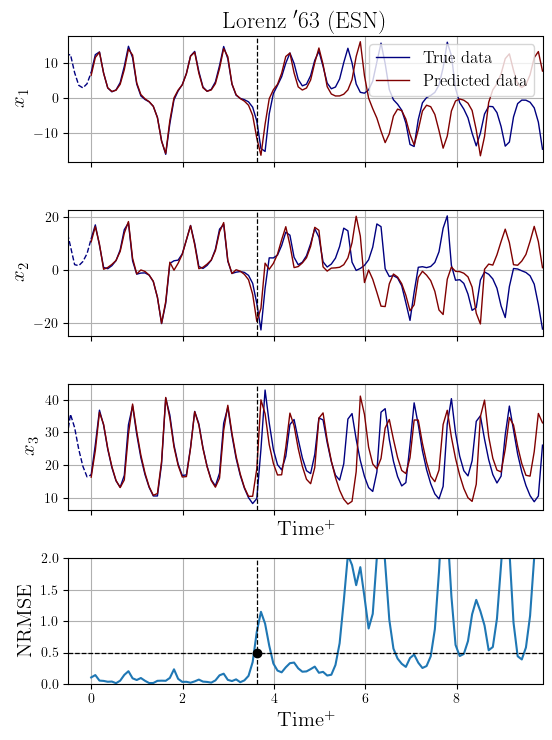

In [47]:
lyap_time = np.mean(lyapunov_time_arr)

d_idx = 52#np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
print('d_idx : {}'.format(d_idx))

num_sample_input_AR = prediction.shape[-2]
num_sample_input_AR = AR_testing_data_rnn_input.shape[-2]

n = 1
num_latent_states = prediction.shape[-1]
N = prediction.shape[-2]#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states+1

ax_ylabels = [r'$x_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states+1, 1, sharex=True, figsize=np.array([7.5*num_cols, 2.5*num_rows])*0.75)
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR+1) - num_sample_input_AR)*dt_rnn
# time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
# time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup1[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

din_shape = np.array(AR_testing_data_rnn_input[d_idx].shape)
din_shape[0] += 1
data_in_plot = np.empty(shape=din_shape)
data_in_plot[:-1] = AR_testing_data_rnn_input[d_idx]
data_in_plot[-1] = AR_testing_data_rnn_output[d_idx, 0]
data_out_plot = np.empty_like(AR_testing_data_rnn_output[d_idx])
data_out_plot[:] = AR_testing_data_rnn_output[d_idx]

data_in_plot = invert_normalization(data_in_plot, normalization_constant_arr_aedata)
data_out_plot = invert_normalization(data_out_plot, normalization_constant_arr_aedata)


for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_in_plot[:, j], linestyle='--', linewidth=1, color=colors[2*i], label='__nolabel__')#'actual warmup data')#.format(i+1))
        # ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_out_plot[:, j], linewidth=1, color=colors[2*i], label='True data')# .format(i+1))
        ax[j].plot(input_time, prediction[d_idx, :, j], linewidth=1, color=colors[2*i+1], label='Predicted data')#.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j], **ylabel_kwargs)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    # ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-2].set_xlabel('Time$^+$', **xlabel_kwargs)

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc=1,
    ncol=ncols,
    **legend_kwargs,
)
ax[0].set_title(r"Lorenz $'63$ (ESN)", **title_kwargs)


### error computation
error = (data_out_plot - prediction[d_idx])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev_ogdata**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

# fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2 = ax[-1]
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$', **xlabel_kwargs)
ax2.set_ylabel('NRMSE', **ylabel_kwargs)

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if len(predhor_idx.shape) == 0 or predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
# ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
# ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.plot(input_time[predhor_idx], error_threshold, 'o', color='k')
ax2.axhline(error_threshold, linewidth=0.9, linestyle='--', color='k')

for i in range(len(ax)):
    ax[i].axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 2])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.tight_layout()

plt.savefig(dir_name_rnn+'/plots/time_prediction.pdf', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

np.savez(
    dir_name_rnn+'/plots/time_prediction',
    data_in_plot=data_in_plot,
    data_out_plot=data_out_plot,
    prediction=prediction[d_idx],
    normalization_constant_arr_aedata=normalization_constant_arr_aedata,
)

In [48]:
# predhor_idx.shape

In [49]:
if use_weights_post_dense == True:
    print(rnn_net.postWout.individual_weights)

### Prediction horizon computation